Some code fragments to help you start. Yoi will need to (obviously) set paths tp your own data area.

In [3]:
import pandas as pd
import numpy as np

# to get data from a FITS table
from astropy.io import fits
from astropy.table import Table

# to convert RA dec into actual form
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5

The master catalog is based on the Revised Bologna Catalog and includes known GCs as well as obejct that have been thought to be GCs. We need GCs (1), extended GCs (8) and the galaxies (4)

     1 = globular cluster;
     2 = candidate globular cluster;
     3 = controversial object;
     4 = galaxy;
     5 = HII region
     6 = star(s)
     7 = asterism;
     8 = extended cluster;
     

In [14]:
master_catalog_df = pd.read_csv('master_catalog_sept_2024.csv')
master_catalog_df

,ID,RADEG,DECDEG,CLASS,DATATABLE
0,C1,0.157917,32.417778,2,di_tullio_zinn_13_table2
1,2M034,0.508375,51.606722,4,m31rbcV5
2,PAndAS-03,0.985042,40.888667,1,huxor14_table1
3,PAndAS-04,1.178875,47.361797,1,huxor14_table1
4,PAndAS-05,1.350625,43.926583,1,huxor14_table1
...,...,...,...,...,...
2266,C74,356.707917,45.247222,2,di_tullio_zinn_13_table2
2267,C75,357.170417,39.629167,2,di_tullio_zinn_13_table2
2268,SDSS18,357.290417,40.458333,4,di_tullio_zinn_13_table1
2269,PAndAS-01,359.300125,43.552300,1,huxor14_table1


Read in CFHT data of PandAS pointings

data from https://www.canfar.net/storage/list/PANDAS/PUBLIC


In [15]:
# load data of exposures from file in
# https://ws-sf.canfar.net/transfer/bmVpZ2g9U0ZVJnNpZ2V4cD0yMDIyMDcxMDE1MDc0NiZhcmM9Vk9TcGFjJmlkPTI0OTEwOTU0MCZ1c2VyPWFub25Vc2VyJm5zPVBBTkRBUyUyRlBVQkxJQyUyRkRPQ1MmbWV0aD1nZXQmYXV0aENvZGU9MCZydW5JRD1nOXNuZ2R2NnN1Z3E1ODNwJnVybD1odHRwJTNBJTJGJTJGc3Rvci1zZi0wMS5jYW5mYXIubmV0JTNBODg4OCUyRmFyY2hpdmUlMkY1ODA0MzQyYyUyRjE4ODklMkZ2b3NwYWMlMkZkZWZhdWx0JTJGMDAlMkYyNCUyRjcwJTJGMjQ5MTA5NTQwJTI1M0IlMjUzQjI3OTA0NDgzNw==-ZmlkPVRhYmxlMi50eHQmY2xuPTMwOTcyMiZjbWQ9MDQ4MWJjZWRlYWMwYjQ2ZTQxMDU3Y2I4YWUyMzg4OTQmbG1kPTE1Mzk3OTUxNzQ2NTM=-f7464048a902d90fb6fe371739d641b6/Table2.txt

pandas_obs_log = pd.read_csv('pandas_observing_log.txt',skiprows=35, header=None, delimiter=r"\s+")
col_names = ['obs_year','obs_month','obs_day','obs_hour','obs_min','obs_sec','mjd','RAh','RAm','RAs',\
         'DECd','DECm','DECs','ExpID','FieldID','OtherID','PID','Filter','Exp']
pandas_obs_log.columns = col_names
print(pandas_obs_log.head(2))

# concat coord columns into one string for astropy to use
pandas_obs_log['coord_string'] = pandas_obs_log['RAh'].astype(str)+' '+pandas_obs_log['RAm'].astype(str)+' '+ \
    pandas_obs_log['RAs'].astype(str)+' '+pandas_obs_log['DECd'].astype(str)+' '+pandas_obs_log['DECm'].astype(str)\
    +' '+pandas_obs_log['DECs'].astype(str)
                                                      
pandas_obs_log['coord_astropy'] = pandas_obs_log['coord_string'].apply(lambda x: SkyCoord(x, unit=(u.hourangle, u.deg)))
pandas_obs_log['coord_ra_deg'] = pandas_obs_log['coord_astropy'].apply(lambda x: x.ra.deg)
pandas_obs_log['coord_dec_deg'] = pandas_obs_log['coord_astropy'].apply(lambda x: x.dec.deg)

   obs_year  obs_month  obs_day  obs_hour  obs_min  obs_sec           mjd  \
0      2003          8       22        11       29    38.27  52873.478915   
1      2003          8       22        11       53    39.54  52873.495596   

   RAh  RAm   RAs  DECd  DECm  DECs   ExpID FieldID OtherID     PID    Filter  \
0    1   33  51.0    30    39  36.8  714745    m026    M33C  03BF15  g.MP9401   
1    1   33  51.0    30    39  36.8  714747    m026    M33C  03BF15  i.MP9701   

   Exp  
0  530  
1  660  


In [16]:
# group by field_id, the main way to identify a pointing,
# to then average the ra/dec form the various offset pointings
pandas_field_centres = pandas_obs_log.groupby('FieldID')[['coord_ra_deg','coord_dec_deg']].mean()

pandas_field_centres

,coord_ra_deg,coord_dec_deg
FieldID,,
m001,24.564181,27.638144
m002,23.464174,27.658144
m003,22.364174,27.938134
m004,24.564194,28.638148
m005,23.464194,28.658153
...,...,...
m402,8.127160,49.137894
m403,9.522208,49.736528
m404,5.188090,50.085593


In [17]:
# save pandas field centres
pandas_field_centres.to_csv('pandas_field_centres.csv')

<Axes: xlabel='coord_ra_deg', ylabel='coord_dec_deg'>

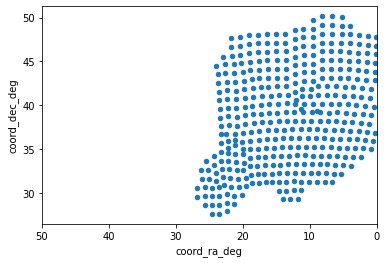

In [6]:
pandas_field_centres.plot.scatter(x='coord_ra_deg',y='coord_dec_deg',xlim=(50,0))


<Axes: xlabel='coord_ra_deg', ylabel='coord_dec_deg'>

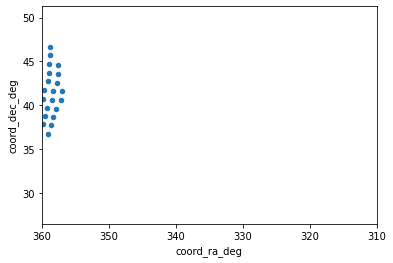

In [7]:
pandas_field_centres.plot.scatter(x='coord_ra_deg',y='coord_dec_deg',xlim=(360,310))


In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Create SkyCoord objects for the master catalog and the pandas field centers
object_coords = SkyCoord(ra=master_catalog_df['RADEG'].values * u.deg,
                         dec=master_catalog_df['DECDEG'].values * u.deg,
                         frame='fk5')

NameError: name 'master_catalog_df' is not defined

In [9]:
field_coords = SkyCoord(ra=pandas_field_centres['coord_ra_deg'].values * u.deg,
                        dec=pandas_field_centres['coord_dec_deg'].values * u.deg,
                        frame='fk5')

In [10]:
# Use match_to_catalog_sky to find the closest field center for each object
idx, d2d, _ = object_coords.match_to_catalog_sky(field_coords)

In [11]:
# Collect the results
object_id = master_catalog_df['ID'].values
best_fit_pointing = pandas_field_centres.index.values[idx]  
min_dist = d2d.deg  # Minimum distances in degrees

Note that some object are not in any fields, and will have minimum distances greater than about 0.7 degs. Recall each field about 1x1 deg, so onject can be up to the to diagonal distance fom the centre - sqrt(0.5^2 + 0.5^2) ~0.7 

In [12]:
result_df = pd.DataFrame({
    'Object ID': object_id,
    'Nearest field': best_fit_pointing,
    'Distance to nearest field': min_dist
})
result_df.to_csv('result_new.csv')

In [13]:
result_df

,Object ID,Nearest field,Distance to nearest field
0,C1,m095,2.539979
1,2M034,m404,3.322483
2,PAndAS-03,m243,0.023986
3,PAndAS-04,m368,0.467914
4,PAndAS-05,m310,0.127090
...,...,...,...
2266,C74,m323,0.881098
2267,C75,m215,0.585970
2268,SDSS18,m238,0.189372
2269,PAndAS-01,m305,0.309150


Gets nearest fields for a specific class of objects

In [36]:
# Using master catalog:
    # Filter for specific class (1 (GCs),8 extended GC),4 (galaxy))
    # Make sure to store rad and dec
filtered_catalog_df = master_catalog_df[master_catalog_df['CLASS'] == 4]
filtered_catalog_df.head()

,ID,RADEG,DECDEG,CLASS,DATATABLE
1,2M034,0.508375,51.606722,4,m31rbcV5
5,2M035,1.549625,41.503722,4,m31rbcV5
7,C2,2.079167,34.468611,4,di_tullio_zinn_13_table2
8,C3,2.143750,34.627222,4,di_tullio_zinn_13_table2
18,2M031,4.089208,34.200056,4,m31rbcV5


In [37]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Create SkyCoord objects for the master catalog and the pandas field centers
object_coords = SkyCoord(ra=filtered_catalog_df['RADEG'].values * u.deg,
                         dec=filtered_catalog_df['DECDEG'].values * u.deg,
                         frame='fk5')

In [38]:
field_coords = SkyCoord(ra=pandas_field_centres['coord_ra_deg'].values * u.deg,
                        dec=pandas_field_centres['coord_dec_deg'].values * u.deg,
                        frame='fk5')

In [39]:
# Use match_to_catalog_sky to find the closest field center for each object
idx, d2d, _ = object_coords.match_to_catalog_sky(field_coords)

In [40]:
# Collect the results
object_id = filtered_catalog_df['ID'].values
raddeg = filtered_catalog_df['RADEG'].values
decdeg = filtered_catalog_df['DECDEG'].values
best_fit_pointing = pandas_field_centres.index.values[idx]  
min_dist = d2d.deg  # Minimum distances in degrees

In [41]:
result_df = pd.DataFrame({
    'Object ID': object_id,
    'RADEG': raddeg,
    'DECDEG': decdeg,
    'Nearest field': best_fit_pointing,
    'Distance to nearest field': min_dist
})
result_df.to_csv('result_G.csv')

Find all the fields for a different csv

In [2]:
import pandas as pd
import numpy as np

# Load the data
yilun_data = pd.read_csv('rootness_initial_sample.csv')
field_centres = pd.read_csv('pandas_field_centres.csv')

# Function to calculate the Haversine distance between two points
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

# Prepare the result dataframe
result = []

# Iterate over each row in the Yilun data
for index, yilun_row in yilun_data.iterrows():
    min_distance = float('inf')
    nearest_field = None
    
    # Iterate over each row in the field centres data
    for _, field_row in field_centres.iterrows():
        dist = haversine(yilun_row['RAJ2000'], yilun_row['DEJ2000'], field_row['coord_ra_deg'], field_row['coord_dec_deg'])
        if dist < min_distance:
            min_distance = dist
            nearest_field = field_row['FieldID']
    
    # Append the result
    result.append({
        'RADEG': yilun_row['RAJ2000'],
        'DECDEG': yilun_row['DEJ2000'],
        'Nearest field': nearest_field,
        'Distance to nearest field': min_distance
    })

# Convert the result list to a DataFrame
result_df = pd.DataFrame(result)

# Save the result to a new CSV file
result_df.to_csv('rootness_closest_fields.csv', index=False)

Check if any are outside of the bounds of the fields

Find all the unique fields that these objects are found in

In [2]:
import pandas as pd
import numpy as np

# Load the three csv files
df1 = pd.read_csv('result_GC.csv')
df2 = pd.read_csv('result_G.csv')
df3 = pd.read_csv('result_EGC.csv')

# Get unique values
unique_field_ids1 = df1['Nearest field'].unique()
unique_field_ids2 = df2['Nearest field'].unique()
unique_field_ids3 = df3['Nearest field'].unique()

# Concatenate the unique values
unique_field_ids = np.concatenate((unique_field_ids1, unique_field_ids2, unique_field_ids3))

# Get unique values
unique_field_ids = np.unique(unique_field_ids)

# Order the unique values
unique_field_ids.sort()

# Output
print(unique_field_ids)
print(len(unique_field_ids))

# Print unique field IDs in chunks of 25
chunk_size = 5
for i in range(0, len(unique_field_ids), chunk_size):
    chunk = unique_field_ids[i:i + chunk_size]
    print(f"Chunk {i // chunk_size + 1}: {chunk}")

['m005' 'm011' 'm014' 'm020' 'm022' 'm024' 'm025' 'm033' 'm035' 'm037'
 'm043' 'm052' 'm058' 'm062' 'm070' 'm080' 'm082' 'm084' 'm085' 'm091'
 'm092' 'm094' 'm095' 'm097' 'm102' 'm111' 'm124' 'm125' 'm126' 'm138'
 'm142' 'm146' 'm148' 'm153' 'm161' 'm162' 'm165' 'm167' 'm168' 'm169'
 'm173' 'm180' 'm183' 'm184' 'm185' 'm186' 'm187' 'm188' 'm189' 'm196'
 'm204' 'm205' 'm206' 'm207' 'm208' 'm209' 'm210' 'm211' 'm212' 'm214'
 'm223' 'm224' 'm225' 'm227' 'm228' 'm229' 'm231' 'm232' 'm233' 'm234'
 'm235' 'm238' 'm240' 'm243' 'm248' 'm249' 'm253' 'm254' 'm255' 'm256'
 'm257' 'm261' 'm263' 'm265' 'm266' 'm267' 'm268' 'm269' 'm274' 'm275'
 'm276' 'm277' 'm278' 'm279' 'm280' 'm282' 'm285' 'm286' 'm293' 'm294'
 'm296' 'm297' 'm301' 'm303' 'm304' 'm305' 'm306' 'm307' 'm310' 'm316'
 'm317' 'm319' 'm321' 'm323' 'm327' 'm328' 'm333' 'm334' 'm335' 'm338'
 'm340' 'm341' 'm342' 'm348' 'm351' 'm362' 'm368' 'm375' 'm379' 'm390'
 'm391' 'm392' 'm395' 'm398' 'm402' 'm404']
136
Chunk 1: ['m005' 'm011' 'm014

Get unique fields for just one csv

In [3]:
import pandas as pd
import numpy as np

# Load the CSV file
df = pd.read_csv('rootness_closest_fields.csv')

# Get unique values
unique_field_ids = df['Nearest field'].unique()

# Order the unique values
unique_field_ids.sort()

# Output
print(unique_field_ids)
print(len(unique_field_ids))

# Print unique field IDs in chunks of 25
chunk_size = 35
for i in range(0, len(unique_field_ids), chunk_size):
    chunk = unique_field_ids[i:i + chunk_size]
    print(f"Chunk {i // chunk_size + 1}: {chunk}")

['m105' 'm121' 'm124' 'm138' 'm142' 'm143' 'm144' 'm166' 'm168' 'm187'
 'm188' 'm202' 'm203' 'm205' 'm211' 'm212' 'm222' 'm223' 'm225' 'm228'
 'm229' 'm233' 'm235' 'm245' 'm248' 'm249' 'm250' 'm253' 'm257' 'm265'
 'm266' 'm268' 'm272' 'm274' 'm275' 'm276' 'm285' 'm287' 'm293' 'm294'
 'm298' 'm316' 'm319' 'm327' 'm335' 'm337' 'm339' 'm340' 'm346' 'm347'
 'm356' 'm358' 'm359' 'm364' 'm375' 'm377' 'm382']
57
Chunk 1: ['m105' 'm121' 'm124' 'm138' 'm142' 'm143' 'm144' 'm166' 'm168' 'm187'
 'm188' 'm202' 'm203' 'm205' 'm211' 'm212' 'm222' 'm223' 'm225' 'm228'
 'm229' 'm233' 'm235' 'm245' 'm248' 'm249' 'm250' 'm253' 'm257' 'm265'
 'm266' 'm268' 'm272' 'm274' 'm275']
Chunk 2: ['m276' 'm285' 'm287' 'm293' 'm294' 'm298' 'm316' 'm319' 'm327' 'm335'
 'm337' 'm339' 'm340' 'm346' 'm347' 'm356' 'm358' 'm359' 'm364' 'm375'
 'm377' 'm382']


Convert a fit file into its ccds

In [1]:
from astropy.io import fits
import os
import glob

# Define the input and output directories
input_dir = os.path.expanduser('C:/Users/Squid/Downloads/Fits')
output_dir = '../data/ccd'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get a list of all FITS files in the input directory
fits_files = glob.glob(os.path.join(input_dir, '*.fit'))

# Loop over each FITS file
for fits_file in fits_files:
    print(f"Processing file: {fits_file}")
    try:
        # Open the FITS file
        hdul = fits.open(fits_file)

        # Get the base name of the input file without extension
        base_name = os.path.splitext(os.path.basename(fits_file))[0]

        # Loop through each HDU (Header/Data Unit) in the FITS file
        for i, hdu in enumerate(hdul):
            # Check if the HDU contains image data
            if isinstance(hdu, fits.ImageHDU) or isinstance(hdu, fits.PrimaryHDU) and i != 0:
                # Extract the data
                data = hdu.data
                # Save the data to a new FITS file
                output_filename = os.path.join(output_dir, f'{base_name}_ccd_{i}.fit')
                fits.writeto(output_filename, data, hdu.header, overwrite=True)
                print(f"Created: {output_filename}")

        # Close the FITS file
        hdul.close()

    except Exception as e:
        print(f"An error occurred while processing {fits_file}: {e}\n")

Processing file: C:/Users/Squid/Downloads/Fits\m381_g.fit
Created: ../data/ccd\m381_g_ccd_1.fit
Created: ../data/ccd\m381_g_ccd_2.fit
Created: ../data/ccd\m381_g_ccd_3.fit
Created: ../data/ccd\m381_g_ccd_4.fit
Created: ../data/ccd\m381_g_ccd_5.fit
Created: ../data/ccd\m381_g_ccd_6.fit
Created: ../data/ccd\m381_g_ccd_7.fit
Created: ../data/ccd\m381_g_ccd_8.fit
Created: ../data/ccd\m381_g_ccd_9.fit
Created: ../data/ccd\m381_g_ccd_10.fit
Created: ../data/ccd\m381_g_ccd_11.fit
Created: ../data/ccd\m381_g_ccd_12.fit
Created: ../data/ccd\m381_g_ccd_13.fit
Created: ../data/ccd\m381_g_ccd_14.fit
Created: ../data/ccd\m381_g_ccd_15.fit
Created: ../data/ccd\m381_g_ccd_16.fit
Created: ../data/ccd\m381_g_ccd_17.fit
Created: ../data/ccd\m381_g_ccd_18.fit
Created: ../data/ccd\m381_g_ccd_19.fit
Created: ../data/ccd\m381_g_ccd_20.fit
Created: ../data/ccd\m381_g_ccd_21.fit
Created: ../data/ccd\m381_g_ccd_22.fit
Created: ../data/ccd\m381_g_ccd_23.fit
Created: ../data/ccd\m381_g_ccd_24.fit
Created: ../dat

Created: ../data/ccd\m400_g_ccd_1.fit
Created: ../data/ccd\m400_g_ccd_2.fit
Created: ../data/ccd\m400_g_ccd_3.fit
Created: ../data/ccd\m400_g_ccd_4.fit
Created: ../data/ccd\m400_g_ccd_5.fit
Created: ../data/ccd\m400_g_ccd_6.fit
Created: ../data/ccd\m400_g_ccd_7.fit
Created: ../data/ccd\m400_g_ccd_8.fit
Created: ../data/ccd\m400_g_ccd_9.fit
Created: ../data/ccd\m400_g_ccd_10.fit
Created: ../data/ccd\m400_g_ccd_11.fit
Created: ../data/ccd\m400_g_ccd_12.fit
Created: ../data/ccd\m400_g_ccd_13.fit
Created: ../data/ccd\m400_g_ccd_14.fit
Created: ../data/ccd\m400_g_ccd_15.fit
Created: ../data/ccd\m400_g_ccd_16.fit
Created: ../data/ccd\m400_g_ccd_17.fit
Created: ../data/ccd\m400_g_ccd_18.fit
Created: ../data/ccd\m400_g_ccd_19.fit
Created: ../data/ccd\m400_g_ccd_20.fit
Created: ../data/ccd\m400_g_ccd_21.fit
Created: ../data/ccd\m400_g_ccd_22.fit
Created: ../data/ccd\m400_g_ccd_23.fit
Created: ../data/ccd\m400_g_ccd_24.fit
Created: ../data/ccd\m400_g_ccd_25.fit
Created: ../data/ccd\m400_g_ccd_26

Experimenting the checking of if something is in range

In [14]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

# Step 1: Load the FITS file and extract WCS
fits_file = '/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd35.fit'  # Replace with your FITS file path
with fits.open(fits_file) as hdulist:
    # Adjust the index if your image is not in the primary HDU
    header = hdulist[0].header
    data = hdulist[0].data

# Extract WCS information
wcs = WCS(header)

# Step 2: Define your sky coordinate (RA, Dec)
ra = 24.3  # Right Ascension in degrees
dec = 27.2    # Declination in degrees
sky_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Convert sky coordinate to pixel coordinate
# wcs.world_to_pixel returns (x_pixel, y_pixel)
x_pixel, y_pixel = wcs.world_to_pixel(sky_coord)

# Step 3: Check if pixel coordinates are within image bounds
# Image dimensions
naxis1 = header['NAXIS1']  # Width of the image
naxis2 = header['NAXIS2']  # Height of the image

# Function to check if pixel is within image bounds
def is_within_image(x, y, nx, ny):
    return (0 <= x < nx) and (0 <= y < ny)

if is_within_image(x_pixel, y_pixel, naxis1, naxis2):
    print("The sky coordinate is within the image.")
else:
    print("The sky coordinate is outside the image.")


The sky coordinate is outside the image.


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


In [15]:
! ls /Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd*

/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd1.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd10.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd11.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd12.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd13.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd14.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd15.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd16.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd17.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd18.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd19.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd2.fit
/Users/ahuxor/Astro_projects/G

In [2]:
import glob

# Example: Get all FITS files in a directory
fits_files = glob.glob('../data/m005_g_ccd*.fit')

If we order all the csvs, then just limit the csv based on what mxxx there are.
Code below, for one of the classes, go over all their ccds, if it is within said ccd, extract an image

In [2]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import astropy.units as u
import numpy as np
from astropy.visualization import ZScaleInterval
from PIL import Image
import glob
import os
import pandas as pd

# Define the input and output directories and corresponding CSV files
configurations = [
    {'csv_file': 'Yilun_Wang_selected_closest_fields.csv', 'output_dir': '../data/cutouts'}
    # {'csv_file': 'result_GC.csv', 'output_dir': '../data/cluster_cutouts'},
    # {'csv_file': 'result_EGC.csv', 'output_dir': '../data/extended_cluster_cutouts'}
]
input_dir = '../data/ccd'

# Function to check if pixel is within image bounds
def is_within_image(x, y, nx, ny):
    return (0 <= x < nx) and (0 <= y < ny)

# Function to convert FITS data to PNG with resampling
def fits_to_png(data, output_png, image_size=128, background_grey=94):
    # Replace NaNs or Infs with zeros to avoid issues
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    # Apply Zscale normalization to raw data
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(data)

    # Clip the data to the Zscale range
    clipped_data = np.clip(data, vmin, vmax)

    # Apply asinh scaling on the clipped data
    scaled_data = np.arcsinh(clipped_data)

    # Recompute the min/max for the asinh-transformed data
    scaled_vmin = scaled_data.min()
    scaled_vmax = scaled_data.max()

    # Normalize the scaled data to the range [0, 255] for 8-bit image representation
    scaled_data = (scaled_data - scaled_vmin) / (scaled_vmax - scaled_vmin)
    scaled_data = (scaled_data * 255).astype(np.uint8)

    # Replace black pixels (0 value) with the background grey value
    # scaled_data[scaled_data == 0] = background_grey

    # Create an image using PIL
    img = Image.fromarray(scaled_data)

    # Resize the image if a specific size is provided
    if image_size is not None:
        img = img.resize((image_size, image_size), Image.LANCZOS)

    # Save the image as PNG
    img.save(output_png)

# Process each configuration
for config in configurations:
    csv_file = config['csv_file']
    output_dir = config['output_dir']
    os.makedirs(output_dir, exist_ok=True)

    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Get a list of all FITS files in the input directory
    fits_files = glob.glob(os.path.join(input_dir, '*.fit'))
    fits_basenames = {os.path.basename(f).split('_')[0] for f in fits_files}

    # Filter the DataFrame to only include rows with corresponding FITS files
    df = df[df['Nearest field'].isin(fits_basenames)]
    ra_list = df['RADEG'].values
    dec_list = df['DECDEG'].values

    # Loop over each FITS file
    for fits_file in fits_files:
        # print(f"Processing file: {fits_file}")
        try:
            # Load the FITS file and extract WCS
            with fits.open(fits_file) as hdulist:
                # Adjust the index if your image is not in the primary HDU
                header = hdulist[0].header
                data = hdulist[0].data

                # Extract WCS information
                wcs = WCS(header)

                # Image dimensions
                naxis1 = header['NAXIS1']  # Width of the image
                naxis2 = header['NAXIS2']  # Height of the image

                # Loop over each coordinate in the filtered DataFrame
                for ra, dec in zip(ra_list, dec_list):
                    sky_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

                    # Convert sky coordinate to pixel coordinate
                    x_pixel, y_pixel = wcs.world_to_pixel(sky_coord)

                    # Check if pixel coordinates are within image bounds
                    if is_within_image(x_pixel, y_pixel, naxis1, naxis2):
                        print(f"The sky coordinate ({ra}, {dec}) is within the image.")

                        # Define the size of the cutout (e.g., 100x100 pixels)
                        cutout_size = (100, 100)  # (ny, nx)

                        # Create the cutout
                        cutout = Cutout2D(data, (x_pixel, y_pixel), cutout_size, wcs=wcs)

                        # Save the cutout as a PNG file
                        png_filename = os.path.join(output_dir, f'cutout_{os.path.basename(fits_file).replace(".fit", f"_{ra}_{dec}.png")}')
                        fits_to_png(cutout.data, png_filename)
                        print(f"Cutout saved to: {png_filename}")

        except Exception as e:
            print(f"An error occurred while processing {fits_file}: {e}")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (11.574, 47.828555) is within the image.
Cutout saved to: ../data/cutouts\cutout_m381_g_ccd_10_11.574_47.828555.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (10.222183, 47.686978) is within the image.
Cutout saved to: ../data/cutouts\cutout_m381_g_ccd_27_10.222183_47.686978.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (10.906022, 47.452016) is within the image.
Cutout saved to: ../data/cutouts\cutout_m381_g_ccd_32_10.906022_47.452016.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (10.25293, 47.988597) is within the image.
Cutout saved to: ../data/cutouts\cutout_m381_g_ccd_9_10.25293_47.988597.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (10.222183, 47.686978) is within the image.
Cutout saved to: ../data/cutouts\cutout_m382_g_ccd_19_10.222183_47.686978.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (9.538052, 47.556469) is within the image.
Cutout saved to: ../data/cutouts\cutout_m382_g_ccd_23_9.538052_47.556469.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.808495, 47.557556) is within the image.
Cutout saved to: ../data/cutouts\cutout_m382_g_ccd_27_8.808495_47.557556.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (9.669105, 47.381723) is within the image.
Cutout saved to: ../data/cutouts\cutout_m382_g_ccd_31_9.669105_47.381723.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.801547, 48.169291) is within the image.
Cutout saved to: ../data/cutouts\cutout_m382_g_ccd_9_8.801547_48.169291.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (20.553969, 47.625468) is within the image.
Cutout saved to: ../data/cutouts\cutout_m383_g_ccd_22_20.553969_47.625468.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (20.780487, 48.041985) is within the image.
Cutout saved to: ../data/cutouts\cutout_m383_g_ccd_3_20.780487_48.041985.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (20.506693, 48.040819) is within the image.
Cutout saved to: ../data/cutouts\cutout_m383_g_ccd_4_20.506693_48.040819.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (0.635399, 48.073968) is within the image.
Cutout saved to: ../data/cutouts\cutout_m384_g_ccd_1_0.635399_48.073968.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (0.635399, 48.073968) is within the image.
Cutout saved to: ../data/cutouts\cutout_m385_g_ccd_18_0.635399_48.073968.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (1.72238, 48.237936) is within the image.
Cutout saved to: ../data/cutouts\cutout_m385_g_ccd_3_1.72238_48.237936.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (3.189969, 47.693874) is within the image.
Cutout saved to: ../data/cutouts\cutout_m387_g_ccd_29_3.189969_47.693874.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (2.279475, 48.364497) is within the image.
Cutout saved to: ../data/cutouts\cutout_m387_g_ccd_7_2.279475_48.364497.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (18.228523, 48.059643) is within the image.
Cutout saved to: ../data/cutouts\cutout_m388_g_ccd_11_18.228523_48.059643.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (17.132227, 47.820212) is within the image.
Cutout saved to: ../data/cutouts\cutout_m388_g_ccd_27_17.132227_47.820212.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (18.395156, 47.711116) is within the image.
Cutout saved to: ../data/cutouts\cutout_m388_g_ccd_28_18.395156_47.711116.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (17.464467, 47.597155) is within the image.
Cutout saved to: ../data/cutouts\cutout_m388_g_ccd_34_17.464467_47.597155.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (17.804548, 48.421773) is within the image.
Cutout saved to: ../data/cutouts\cutout_m388_g_ccd_5_17.804548_48.421773.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.626844, 48.260931) is within the image.
Cutout saved to: ../data/cutouts\cutout_m389_g_ccd_10_4.626844_48.260931.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (3.642637, 48.254423) is within the image.
Cutout saved to: ../data/cutouts\cutout_m389_g_ccd_16_3.642637_48.254423.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.721539, 48.016727) is within the image.
Cutout saved to: ../data/cutouts\cutout_m389_g_ccd_19_4.721539_48.016727.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.496625, 47.766195) is within the image.
Cutout saved to: ../data/cutouts\cutout_m389_g_ccd_29_4.496625_47.766195.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (3.683178, 48.579029) is within the image.
Cutout saved to: ../data/cutouts\cutout_m389_g_ccd_7_3.683178_48.579029.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (5.460383, 48.269615) is within the image.
Cutout saved to: ../data/cutouts\cutout_m390_g_ccd_12_5.460383_48.269615.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.626844, 48.260931) is within the image.
Cutout saved to: ../data/cutouts\cutout_m390_g_ccd_17_4.626844_48.260931.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.721539, 48.016727) is within the image.
Cutout saved to: ../data/cutouts\cutout_m390_g_ccd_26_4.721539_48.016727.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (5.44742, 47.701042) is within the image.
Cutout saved to: ../data/cutouts\cutout_m390_g_ccd_30_5.44742_47.701042.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.949949, 47.737419) is within the image.
Cutout saved to: ../data/cutouts\cutout_m390_g_ccd_33_4.949949_47.737419.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.496625, 47.766195) is within the image.
Cutout saved to: ../data/cutouts\cutout_m390_g_ccd_36_4.496625_47.766195.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.791999, 48.428132) is within the image.
Cutout saved to: ../data/cutouts\cutout_m390_g_ccd_7_4.791999_48.428132.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (16.11209, 48.26062) is within the image.
Cutout saved to: ../data/cutouts\cutout_m391_g_ccd_16_16.11209_48.26062.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (16.784357, 47.685498) is within the image.
Cutout saved to: ../data/cutouts\cutout_m391_g_ccd_30_16.784357_47.685498.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (16.457292, 47.619365) is within the image.
Cutout saved to: ../data/cutouts\cutout_m391_g_ccd_32_16.457292_47.619365.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (16.190906, 48.531391) is within the image.
Cutout saved to: ../data/cutouts\cutout_m391_g_ccd_6_16.190906_48.531391.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (15.109902, 48.039672) is within the image.
Cutout saved to: ../data/cutouts\cutout_m392_g_ccd_22_15.109902_48.039672.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (14.714501, 47.901624) is within the image.
Cutout saved to: ../data/cutouts\cutout_m392_g_ccd_25_14.714501_47.901624.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (14.567445, 48.081189) is within the image.
Cutout saved to: ../data/cutouts\cutout_m392_g_ccd_26_14.567445_48.081189.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (14.712664, 47.653926) is within the image.
Cutout saved to: ../data/cutouts\cutout_m392_g_ccd_34_14.712664_47.653926.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (14.279342, 47.862121) is within the image.
Cutout saved to: ../data/cutouts\cutout_m392_g_ccd_36_14.279342_47.862121.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (14.792942, 48.574295) is within the image.
Cutout saved to: ../data/cutouts\cutout_m392_g_ccd_6_14.792942_48.574295.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (14.279342, 47.862121) is within the image.
Cutout saved to: ../data/cutouts\cutout_m393_g_ccd_28_14.279342_47.862121.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (6.050245, 48.291811) is within the image.
Cutout saved to: ../data/cutouts\cutout_m394_g_ccd_18_6.050245_48.291811.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (7.032969, 48.10094) is within the image.
Cutout saved to: ../data/cutouts\cutout_m394_g_ccd_21_7.032969_48.10094.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (6.777431, 47.851317) is within the image.
Cutout saved to: ../data/cutouts\cutout_m394_g_ccd_31_6.777431_47.851317.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.755915, 48.59004) is within the image.
Cutout saved to: ../data/cutouts\cutout_m395_g_ccd_1_8.755915_48.59004.png
The sky coordinate (8.801547, 48.169291) is within the image.
Cutout saved to: ../data/cutouts\cutout_m395_g_ccd_10_8.801547_48.169291.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.599014, 48.372806) is within the image.
Cutout saved to: ../data/cutouts\cutout_m395_g_ccd_11_8.599014_48.372806.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.270117, 48.184112) is within the image.
Cutout saved to: ../data/cutouts\cutout_m395_g_ccd_13_8.270117_48.184112.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.521929, 48.104229) is within the image.
Cutout saved to: ../data/cutouts\cutout_m395_g_ccd_21_8.521929_48.104229.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.095838, 47.997353) is within the image.
Cutout saved to: ../data/cutouts\cutout_m395_g_ccd_23_8.095838_47.997353.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.431023, 48.600061) is within the image.
Cutout saved to: ../data/cutouts\cutout_m395_g_ccd_3_8.431023_48.600061.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (7.552902, 48.465202) is within the image.
Cutout saved to: ../data/cutouts\cutout_m395_g_ccd_8_7.552902_48.465202.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (12.859575, 48.960821) is within the image.
Cutout saved to: ../data/cutouts\cutout_m396_g_ccd_1_12.859575_48.960821.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (12.627822, 48.065792) is within the image.
Cutout saved to: ../data/cutouts\cutout_m396_g_ccd_29_12.627822_48.065792.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (11.314694, 48.308261) is within the image.
Cutout saved to: ../data/cutouts\cutout_m397_g_ccd_30_11.314694_48.308261.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (9.739549, 48.819328) is within the image.
Cutout saved to: ../data/cutouts\cutout_m398_g_ccd_13_9.739549_48.819328.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (9.578037, 48.557292) is within the image.
Cutout saved to: ../data/cutouts\cutout_m398_g_ccd_23_9.578037_48.557292.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (9.578457, 48.457107) is within the image.
Cutout saved to: ../data/cutouts\cutout_m398_g_ccd_32_9.578457_48.457107.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.344263, 49.115287) is within the image.
Cutout saved to: ../data/cutouts\cutout_m399_g_ccd_12_4.344263_49.115287.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.452792, 48.873228) is within the image.
Cutout saved to: ../data/cutouts\cutout_m399_g_ccd_20_4.452792_48.873228.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (5.869352, 49.222022) is within the image.
Cutout saved to: ../data/cutouts\cutout_m400_g_ccd_10_5.869352_49.222022.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (5.231674, 48.898035) is within the image.
Cutout saved to: ../data/cutouts\cutout_m400_g_ccd_23_5.231674_48.898035.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.452792, 48.873228) is within the image.
Cutout saved to: ../data/cutouts\cutout_m400_g_ccd_27_4.452792_48.873228.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (7.067065, 49.311399) is within the image.
Cutout saved to: ../data/cutouts\cutout_m401_g_ccd_11_7.067065_49.311399.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (6.736634, 49.276078) is within the image.
Cutout saved to: ../data/cutouts\cutout_m401_g_ccd_13_6.736634_49.276078.png
The sky coordinate (6.687547, 49.272901) is within the image.
Cutout saved to: ../data/cutouts\cutout_m401_g_ccd_14_6.687547_49.272901.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (6.672968, 49.296678) is within the image.
Cutout saved to: ../data/cutouts\cutout_m401_g_ccd_14_6.672968_49.296678.png
The sky coordinate (6.706293, 49.272416) is within the image.
Cutout saved to: ../data/cutouts\cutout_m401_g_ccd_14_6.706293_49.272416.png
The sky coordinate (6.642419, 49.274912) is within the image.
Cutout saved to: ../data/cutouts\cutout_m401_g_ccd_14_6.642419_49.274912.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (7.577692, 49.355394) is within the image.
Cutout saved to: ../data/cutouts\cutout_m402_g_ccd_17_7.577692_49.355394.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.449784, 48.995935) is within the image.
Cutout saved to: ../data/cutouts\cutout_m402_g_ccd_21_8.449784_48.995935.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.230279, 48.8731) is within the image.
Cutout saved to: ../data/cutouts\cutout_m402_g_ccd_31_8.230279_48.8731.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (7.59287, 48.877151) is within the image.
Cutout saved to: ../data/cutouts\cutout_m402_g_ccd_35_7.59287_48.877151.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.986751, 49.879569) is within the image.
Cutout saved to: ../data/cutouts\cutout_m403_g_ccd_17_8.986751_49.879569.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (9.149664, 49.722609) is within the image.
Cutout saved to: ../data/cutouts\cutout_m403_g_ccd_25_9.149664_49.722609.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (9.227293, 50.064239) is within the image.
Cutout saved to: ../data/cutouts\cutout_m403_g_ccd_7_9.227293_50.064239.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.870515, 50.015634) is within the image.
Cutout saved to: ../data/cutouts\cutout_m403_g_ccd_9_8.870515_50.015634.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.89219, 50.149287) is within the image.
Cutout saved to: ../data/cutouts\cutout_m404_g_ccd_16_4.89219_50.149287.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (5.914287, 49.688538) is within the image.
Cutout saved to: ../data/cutouts\cutout_m404_g_ccd_28_5.914287_49.688538.png
The sky coordinate (5.908595, 49.65135) is within the image.
Cutout saved to: ../data/cutouts\cutout_m404_g_ccd_28_5.908595_49.65135.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.718824, 49.781574) is within the image.
Cutout saved to: ../data/cutouts\cutout_m404_g_ccd_35_4.718824_49.781574.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.784436, 50.574086) is within the image.
Cutout saved to: ../data/cutouts\cutout_m404_g_ccd_7_4.784436_50.574086.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (5.979532, 50.285628) is within the image.
Cutout saved to: ../data/cutouts\cutout_m405_g_ccd_18_5.979532_50.285628.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (7.287778, 50.093274) is within the image.
Cutout saved to: ../data/cutouts\cutout_m405_g_ccd_19_7.287778_50.093274.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (6.509104, 49.699002) is within the image.
Cutout saved to: ../data/cutouts\cutout_m405_g_ccd_33_6.509104_49.699002.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (5.914287, 49.688538) is within the image.
Cutout saved to: ../data/cutouts\cutout_m405_g_ccd_36_5.914287_49.688538.png
The sky coordinate (5.908595, 49.65135) is within the image.
Cutout saved to: ../data/cutouts\cutout_m405_g_ccd_36_5.908595_49.65135.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.541289, 50.346824) is within the image.
Cutout saved to: ../data/cutouts\cutout_m406_g_ccd_12_8.541289_50.346824.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.056955, 50.18079) is within the image.
Cutout saved to: ../data/cutouts\cutout_m406_g_ccd_14_8.056955_50.18079.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.870515, 50.015634) is within the image.
Cutout saved to: ../data/cutouts\cutout_m406_g_ccd_19_8.870515_50.015634.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.593124, 50.068956) is within the image.
Cutout saved to: ../data/cutouts\cutout_m406_g_ccd_20_8.593124_50.068956.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (7.707524, 50.081434) is within the image.
Cutout saved to: ../data/cutouts\cutout_m406_g_ccd_25_7.707524_50.081434.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


Change image resolution

In [ ]:
import os
from PIL import Image

def resize_images(input_folder, output_folder, new_resolution):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)
            img = img.resize((new_resolution, new_resolution), Image.ANTIALIAS)
            img.save(os.path.join(output_folder, filename))

input_folder = '../data/cutouts/cluster_cutouts'
output_folder = '../data/cutouts/downsample/cluster_cutouts'
new_resolution = 64

resize_images(input_folder, output_folder, new_resolution)

Mark Dupes/Patial

In [10]:
import os
import glob

# Define the directory containing the files
directory = '../finalised_cutouts/extended_cluster_cutouts'

# Get a list of all files in the directory
files = glob.glob(os.path.join(directory, '*.png'))

# Dictionary to store filenames by coordinates
coord_dict = {}

# First pass: Identify all coordinates that have duplicates
for file in files:
    # Extract the base name of the file
    base_name = os.path.basename(file)
    
    # Extract the coordinates from the filename
    parts = base_name.split('_')
    coords = f"{parts[-2]}_{parts[-1].replace('.png', '')}"
    
    # Add the file to the dictionary
    if coords in coord_dict:
        coord_dict[coords].append(file)
    else:
        coord_dict[coords] = [file]

# Second pass: Rename files with duplicate coordinates
for coords, file_list in coord_dict.items():
    if len(file_list) > 1:
        for file in file_list:
            base_name = os.path.basename(file)
            parts = base_name.split('_')
            new_name = f"{'_'.join(parts[:-2])}_{coords}_partial.png"
            new_path = os.path.join(directory, new_name)
            os.rename(file, new_path)
            print(f"Renamed {file} to {new_path}")

Finds all images with a specific label and moves them to a new folder

In [9]:
import os
import shutil

def move_files_with_word(src_folder, dest_folder, word):
    # Create the destination folder if it doesn't exist
    os.makedirs(dest_folder, exist_ok=True)

    # Loop through all files in the source folder
    for filename in os.listdir(src_folder):
        # Check if the word is in the filename
        if word in filename:
            # Construct full file path
            src_file = os.path.join(src_folder, filename)
            dest_file = os.path.join(dest_folder, filename)
            # Move the file
            shutil.move(src_file, dest_file)
            print(f"Moved: {src_file} to {dest_file}")

# Define the source and destination folders and the word to search for
src_folder = '../finalised_cutouts/galaxy_cutouts'
dest_folder = '../finalised_cutouts/partials/galaxy'
word = 'partial'

# Call the function
move_files_with_word(src_folder, dest_folder, word)

Moved: ../finalised_cutouts/galaxy_cutouts/cutout_m232_g_ccd_15_11.9368917_40.19365_partial.png to ../finalised_cutouts/partials/galaxy/cutout_m232_g_ccd_15_11.9368917_40.19365_partial.png
Moved: ../finalised_cutouts/galaxy_cutouts/cutout_m232_g_ccd_18_11.525375_40.37388888888889_partial.png to ../finalised_cutouts/partials/galaxy/cutout_m232_g_ccd_18_11.525375_40.37388888888889_partial.png
Moved: ../finalised_cutouts/galaxy_cutouts/cutout_m235_g_ccd_23_12.0695208_40.3641167_partial.png to ../finalised_cutouts/partials/galaxy/cutout_m235_g_ccd_23_12.0695208_40.3641167_partial.png
Moved: ../finalised_cutouts/galaxy_cutouts/cutout_m214_g_ccd_16_11.0786042_39.7559861_partial.png to ../finalised_cutouts/partials/galaxy/cutout_m214_g_ccd_16_11.0786042_39.7559861_partial.png
Moved: ../finalised_cutouts/galaxy_cutouts/cutout_m214_g_ccd_35_10.8712667_39.1952833_partial.png to ../finalised_cutouts/partials/galaxy/cutout_m214_g_ccd_35_10.8712667_39.1952833_partial.png
Moved: ../finalised_cutouts

Create an image from a given location



Filename: /Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/individual_images/001_ccd1.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       0 PrimaryHDU     829   (2158, 4689)   float32   
None
<SkyCoord (ICRS): (ra, dec) in deg
    (25.03395833, 27.95960833)>
[array(695.07090836), array(3550.50835852)]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


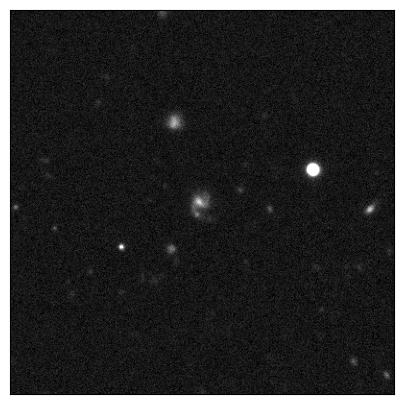

In [18]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import matplotlib.pyplot as plt
import astropy.units as u

# Load the FITS file
fits_image_filename = '/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/individual_images/001_ccd1.fit'
hdulist = fits.open(fits_image_filename)
print(hdulist.info())

# Extract header and data from the primary HDU
header = hdulist['PRIMARY'].header
data = hdulist['PRIMARY'].data
hdulist.close()

# Create a WCS (World Coordinate System) object
wcs = WCS(header)

# Define the sky coordinate of the center
c0 = SkyCoord('01h40m08.15s', '+27d57m34.59s', frame='icrs')
print(c0)

# Convert sky coordinate to pixel coordinate
center = wcs.all_world2pix(c0.ra, c0.dec, 0)
print(center)

# Define the size of the cutout
size = 400  # pixels

# Create a cutout of the image around the specified center
cutout = Cutout2D(data, center, size, wcs=wcs)

# Plot the cutout image
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=cutout.wcs)
ax.imshow(cutout.data, cmap='gray', origin='lower', vmin=2000, vmax=2500)

# Remove axes labels
ax.set_xlabel('')
ax.set_ylabel('')

# Optionally, remove tick labels if desired
ax.coords[0].set_ticklabel_visible(False)  # RA axis
ax.coords[1].set_ticklabel_visible(False)  # Dec axis

# Optionally, remove the ticks themselves
ax.coords[0].set_ticks_visible(False)      # RA axis
ax.coords[1].set_ticks_visible(False)      # Dec axis
plt.savefig('bar.png')

plt.show()


Cross reference a CSV of coords with a folder of images, checking if any are known cluster/non-cluster

In [2]:
import os
import pandas as pd

# Load the CSV files
csv_files = {
    'result_G.csv': 'galaxy',
    'result_GC.csv': 'cluster',
    'result_EGC.csv': 'extended_cluster'
}

# Directory containing the images
image_directory = '../data/predictions/non-cluster'  # Replace with your image directory

# Iterate over each CSV file
for csv_file, label in csv_files.items():
    df = pd.read_csv(csv_file)
    
    # Iterate over each file in the image directory
    for filename in os.listdir(image_directory):
        file_path = os.path.join(image_directory, filename)
        
        # Check if the file is an image
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Extract RA and DEC from the filename
            ra_dec_in_filename = False
            for index, row in df.iterrows():
                ra = str(row['RADEG'])
                dec = str(row['DECDEG'])
                if ra in filename and dec in filename:
                    ra_dec_in_filename = True
                    break
            
            # Determine the new filename
            if ra_dec_in_filename:
                new_filename = filename.replace('.png', f'_{label}_known.png').replace('.jpg', f'_{label}_known.jpg').replace('.jpeg', f'_{label}_known.jpeg').replace('.bmp', f'_{label}_known.bmp')
                new_file_path = os.path.join(image_directory, new_filename)
                os.rename(file_path, new_file_path)
                print(f"Renamed {file_path} to {new_file_path}")

Cross Reference Master Catalogue and Yilun Wang Observations

In [27]:
import pandas as pd

# Load the CSV files
master_catalog_file = 'master_catalog_sept_2024.csv'
result_comparison_file = 'result_comparison.csv'
output_file = 'cross_referenced_results.csv'

# Read the CSV files into DataFrames
master_catalog_df = pd.read_csv(master_catalog_file)
result_comparison_df = pd.read_csv(result_comparison_file)

# Filter the master catalog to only include classes 1, 4, and 8
filtered_master_catalog_df = master_catalog_df[master_catalog_df['CLASS'].isin([1, 4, 8])]

# Create rounded columns for comparison
filtered_master_catalog_df['RADEG_ROUNDED'] = filtered_master_catalog_df['RADEG'].round(3)
filtered_master_catalog_df['DECDEG_ROUNDED'] = filtered_master_catalog_df['DECDEG'].round(3)
result_comparison_df['RADEG_ROUNDED'] = result_comparison_df['RADEG'].round(3)
result_comparison_df['DECDEG_ROUNDED'] = result_comparison_df['DECDEG'].round(3)

# Merge the DataFrames on the rounded RADEG and DECDEG columns
merged_df = pd.merge(filtered_master_catalog_df, result_comparison_df, on=['RADEG_ROUNDED', 'DECDEG_ROUNDED'])

# Drop the rounded columns from the merged DataFrame
merged_df.drop(columns=['RADEG_ROUNDED', 'DECDEG_ROUNDED'], inplace=True)

# Write the merged DataFrame to a new CSV file
merged_df.to_csv(output_file, index=False)

# Print the number of objects in each class in the resulting DataFrame
class_counts = merged_df['CLASS'].value_counts()
print("Number of objects in each class in the resulting DataFrame:")
print(class_counts)

print(f"Cross-referenced results saved to {output_file}")

Number of objects in each class in the resulting DataFrame:
CLASS
1    369
4      2
Name: count, dtype: int64
Cross-referenced results saved to cross_referenced_results.csv


/var/folders/vm/3kcxfy7s46n9ys_x6mqcsj_40000gn/T/ipykernel_6728/3560972722.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_master_catalog_df['RADEG_ROUNDED'] = filtered_master_catalog_df['RADEG'].round(3)
/var/folders/vm/3kcxfy7s46n9ys_x6mqcsj_40000gn/T/ipykernel_6728/3560972722.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_master_catalog_df['DECDEG_ROUNDED'] = filtered_master_catalog_df['DECDEG'].round(3)


Count how many of the cross referenced clusters exist in each class of predictions

In [1]:
import os
import pandas as pd

# Load the CSV files
cross_referenced_file = 'cross_referenced_results.csv'
cross_referenced_df = pd.read_csv(cross_referenced_file)

# Filter the cross-referenced DataFrame to only include class 1 objects
class_1_df = cross_referenced_df[cross_referenced_df['CLASS'] == 1]

# Create a set of RADEG and DECDEG tuples for class 1 objects
class_1_coords = set(zip(class_1_df['RADEG_y'], class_1_df['DECDEG_y']))

# Directories to check
cluster_dir = '../data/predictions_128SRNC/cluster'
non_cluster_dir = '../data/predictions_128SRNC/non-cluster'

# Function to count matching images in a directory
def count_matching_images(directory, coords_set):
    count = 0
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            for ra, dec in coords_set:
                if f"{ra}" in filename and f"{dec}" in filename:
                    count += 1
                    break
    return count

# Count matching images in cluster and non-cluster directories
cluster_count = count_matching_images(cluster_dir, class_1_coords)
non_cluster_count = count_matching_images(non_cluster_dir, class_1_coords)

# Output the results
print(f"Number of class 1 objects in cluster: {cluster_count}")
print(f"Number of class 1 objects in non-cluster: {non_cluster_count}")

Number of class 1 objects in cluster: 425
Number of class 1 objects in non-cluster: 61


Plot of the RADEG and DECDEG on a graph, coloured based on their class

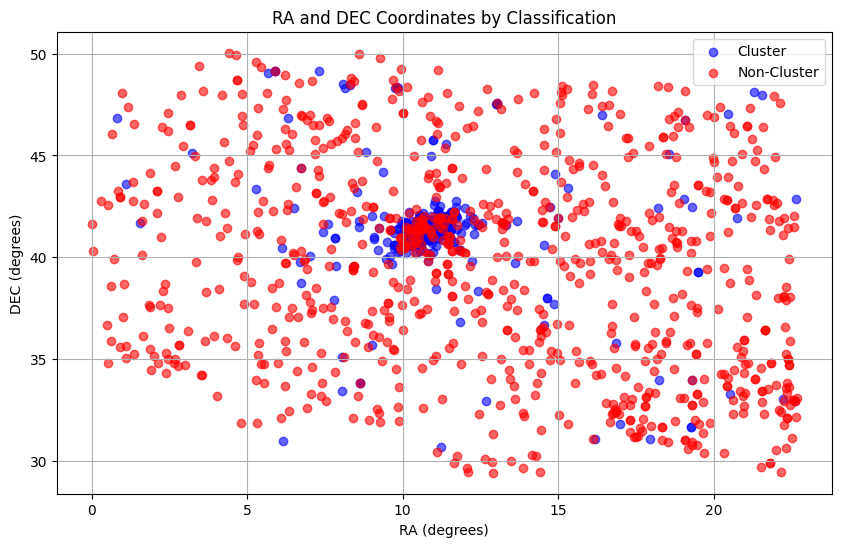

In [3]:
import os
import re
import matplotlib.pyplot as plt

# Directories containing the classified images
cluster_dir = '../data/predictions_128SRNC/cluster'
non_cluster_dir = '../data/predictions_128SRNC/non-cluster'

# Function to extract RA and DEC from filename
def extract_ra_dec(filename):
    match = re.search(r'_(\d+\.\d+)_(\d+\.\d+)\.png$', filename)
    if match:
        ra = float(match.group(1))
        dec = float(match.group(2))
        return ra, dec
    return None, None

# Lists to store RA and DEC values for each class
ra_cluster = []
dec_cluster = []
ra_non_cluster = []
dec_non_cluster = []

# Process cluster images
for filename in os.listdir(cluster_dir):
    if filename.lower().endswith('.png'):
        ra, dec = extract_ra_dec(filename)
        if ra is not None and dec is not None:
            ra_cluster.append(ra)
            dec_cluster.append(dec)

# Process non-cluster images
for filename in os.listdir(non_cluster_dir):
    if filename.lower().endswith('.png'):
        ra, dec = extract_ra_dec(filename)
        if ra is not None and dec is not None:
            ra_non_cluster.append(ra)
            dec_non_cluster.append(dec)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot cluster and non-cluster points with different colors
plt.scatter(ra_cluster, dec_cluster, color='blue', label='Cluster', alpha=0.6)
plt.scatter(ra_non_cluster, dec_non_cluster, color='red', label='Non-Cluster', alpha=0.6)

# Add labels and title
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.title('RA and DEC Coordinates by Classification')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Using the known class one objects, check the location of correct and incorrect

Number of class 1 objects in cluster: 425
Number of class 1 objects in non-cluster: 61


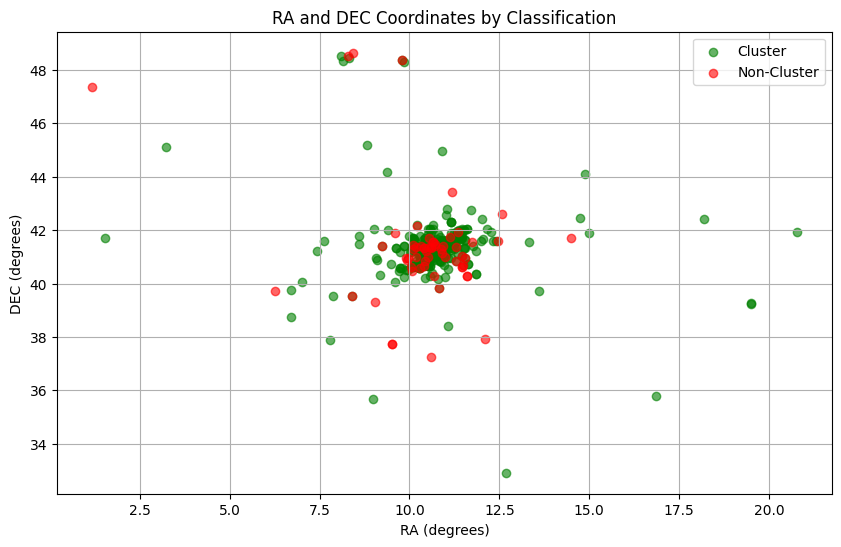

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
cross_referenced_file = 'cross_referenced_results.csv'
cross_referenced_df = pd.read_csv(cross_referenced_file)

# Filter the cross-referenced DataFrame to only include class 1 objects
class_1_df = cross_referenced_df[cross_referenced_df['CLASS'] == 1]

# Create a set of RADEG and DECDEG tuples for class 1 objects
class_1_coords = set(zip(class_1_df['RADEG_y'], class_1_df['DECDEG_y']))

# Directories to check
cluster_dir = '../data/predictions_128SRNC/cluster'
non_cluster_dir = '../data/predictions_128SRNC/non-cluster'

# Lists to store RA and DEC values for plotting
ra_cluster = []
dec_cluster = []
ra_non_cluster = []
dec_non_cluster = []

# Function to count matching images in a directory and collect RA/DEC for plotting
def count_and_collect_images(directory, coords_set, ra_list, dec_list):
    count = 0
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            for ra, dec in coords_set:
                if f"{ra}" in filename and f"{dec}" in filename:
                    count += 1
                    ra_list.append(ra)
                    dec_list.append(dec)
                    break
    return count

# Count matching images in cluster and non-cluster directories and collect RA/DEC for plotting
cluster_count = count_and_collect_images(cluster_dir, class_1_coords, ra_cluster, dec_cluster)
non_cluster_count = count_and_collect_images(non_cluster_dir, class_1_coords, ra_non_cluster, dec_non_cluster)

# Output the results
print(f"Number of class 1 objects in cluster: {cluster_count}")
print(f"Number of class 1 objects in non-cluster: {non_cluster_count}")

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot cluster and non-cluster points with different colors
plt.scatter(ra_cluster, dec_cluster, color='green', label='Cluster', alpha=0.6)
plt.scatter(ra_non_cluster, dec_non_cluster, color='red', label='Non-Cluster', alpha=0.6)

# Add labels and title
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.title('RA and DEC Coordinates by Classification')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Selecting a set number of Yilun Wang Objects

In [1]:
import pandas as pd
import numpy as np

# Load the CSV file
input_file = 'All_Yilun_Wang_data_for_Oscar.csv'
df = pd.read_csv(input_file)

# Filter the DataFrame to only include objects with Pgc < 0.4
filtered_df = df[df['Pgc'] < 0.4]

# Select 10% of the filtered objects
sampled_df = filtered_df.sample(frac=0.1, random_state=42)

# Write the sampled objects to a new CSV file
output_file = 'Yilun_Wang_selected_objects.csv'
sampled_df.to_csv(output_file, index=False)

print(f"Selected {len(sampled_df)} objects and saved to {output_file}")

Selected 1940 objects and saved to Yilun_Wang_selected_objects.csv


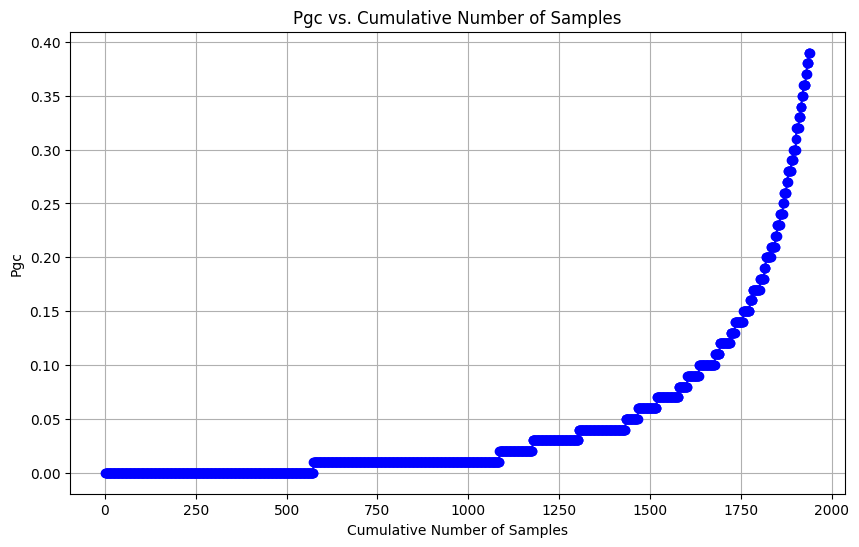

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
input_file = 'Yilun_Wang_selected_objects.csv'
df = pd.read_csv(input_file)

# Sort the DataFrame by Pgc
df_sorted = df.sort_values(by='Pgc')

# Calculate the cumulative number of samples
df_sorted['Cumulative'] = range(1, len(df_sorted) + 1)

# Plot Pgc against the cumulative number of samples
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['Cumulative'], df_sorted['Pgc'], marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Cumulative Number of Samples')
plt.ylabel('Pgc')
plt.title('Pgc vs. Cumulative Number of Samples')
plt.grid(True)

# Show the plot
plt.show()